### 筆記


In [2]:
import numpy as np

def im2col(input_feat: np.ndarray, N, kh, kw, out_h, out_w, stride):
    im2col_feat = []
    for n in range(N):
        for ih in range(out_h):
            for iw in range(out_w):
                im2col_feat.append(input_feat[n, :, stride * ih:stride * ih + kh, stride * iw:stride * iw + kw])
                # each element -> (C, kh, kw)
    # input_feat -> (N*out_h*out_w, C, kh, kw)

    return np.array(im2col_feat).reshape(N * out_h * out_w, -1)

def convolution(input_feat: np.ndarray, filter: np.ndarray, kh, kw, stride=1, padding=0, bias=None):
    '''
    input_feat: (N, C, H, W)
    filter: (out_C, in_C, kH, kw)
    bias: (out_C, 1)
    '''
    N, C, H, W = input_feat.shape
    out_h = int((H - kh + 2 * padding) // stride) + 1
    out_w = int((W - kw + 2 * padding) // stride) + 1
    out_c = filter.shape[0]
    
    if padding:
        input_feat = np.pad(input_feat, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant', constant_values=0)

    im2col_feat = im2col(input_feat, N, kh, kw, out_h, out_w, stride)
    # im2col -> (N*out_h*out_w, C*kh*kw)

    filter = filter.reshape(out_c, -1)
    # filter -> (out_c, C*kh*kw)

    # w @ x.T
    # w -> (out_c, C*kh*kw)
    # x.T -> (C*kh*kw, N*out_h*out_w)
    if isinstance(bias, np.ndarray):
        out_feat = filter @ im2col_feat.T + bias
    else:
        out_feat = filter @ im2col_feat.T
    # out_feat -> (out_c, N*out_h*out_w)
    
    # 直接將 (out_c, N*out_h*out_w) reshape 成 (N, out_c, out_h, out_w) 會產生順序錯亂
    # 所以先將 (out_c, N*out_h*out_w) 拆成 (out_c, N, out_h, out_w) 後再 permute
    # out_feat -> (N, out_c, out_h, out_w)
    return out_feat.reshape(out_c, N, out_h, out_w).transpose(1, 0, 2, 3)
    # return out_feat.T.reshape(N, out_h, out_w, out_c).transpose(0, 3, 1, 2)
   
    
            

In [ ]:
import torch
import torch.nn.functional as F

# input feat (c, h, w) -> (3, 3, 3)
# filter (out_c, in_c, kh, kw) -> (3, 3, 2, 2)
# bias (out_c, 1)
bs = 2
feat_h = 3
feat_w = 3
kh = 2
kw = 2
in_c = 3
out_c = 3
padding = 0
stride = 1

input_feat = np.random.randint(0, 20, size=(bs, in_c, feat_h, feat_w)).astype(np.float32)
filter = np.random.randint(0, 5, size=(out_c, in_c, kh, kw)).astype(np.float32)
# bias = np.random.randint(0, 5, size=(2, 1))
bias = np.zeros((out_c, 1), dtype=np.float32)

out = convolution(input_feat, filter, kh=kh, kw=kw, stride=stride, padding=padding, bias=bias)

# 與 pytorch 的實現方法對照結果
out_t = F.conv2d(torch.tensor(input_feat), torch.tensor(filter), stride=stride, padding=padding, bias=torch.tensor(bias).squeeze(1))


print(f'input feat:\n{input_feat}')
print('======================')
print(f'filter\n:{filter}')
print('======================')
print(f'my out:\n{out}')
print(f'torch out:\n{out_t.numpy()}')
np.allclose(out, out_t)



In [ ]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

def wine():
    with open('data/winequality-red.csv') as f:
        # 跳過 first row (標籤名稱)
        data = f.readlines()[1:]

    data = [line.strip().split(',') for line in data]

    data = np.array(data)
    labels = []

    # 最後一個 column 為 label
    classes = np.unique(data[:, -1])

    # 將 label 做 one-hot encoding
    for d in data:
        for cls in classes:
            if d[-1] == cls:
                one_hot = np.zeros(len(classes))
                one_hot[classes.tolist().index(cls)] = 1
                labels.append(one_hot)
    return data, labels

def iris():
    with open('data/Iris.csv') as f:
    # 跳過 first row (標籤名稱)
        data = f.readlines()[1:]

    data = [line.strip().split(',')[1:] for line in data]
    data = np.array(data)
    labels = []

    classes = np.unique(data[:, 4])

    # 將 label 做 one-hot encoding
    for d in data:
        for cls in classes:
            if d[4] == cls:
                one_hot = np.zeros(len(classes))
                one_hot[classes.tolist().index(cls)] = 1
                labels.append(one_hot)
    return data, labels

# data, labels = iris()
data, labels = wine()
# 將 input features 與 labels 從原始資料中分離
inputs = data[:, :-1].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (80% train, 20% val)
train_size = int(len(X_data) * 0.80)


X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[train_size:], Y_data[train_size:]

hyper_params = {
    'lr': 0.01,
    'epoch': 50,
    'batch_size': 16,
    'alpha': 0.9
}


model = MyModel([Linear(11, 6), 
                 LeckyReLU(),
                 Linear(6, 6),
                 Softmax()])

# model = MyModel([Linear(4, 3), Softmax()])

params = model.train(X_train, Y_train, X_val, Y_val, CrossEntropyLoss, hyper_params, show_plot=True)
# mlp.kfold(X_data, Y_data, FOLD, SquareLoss, hyper_params)


In [6]:
images = np.random.randint(0, 255, size=(4, 3, 5, 5)).astype(np.float32)
labels = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]])

model = MyModel([Conv2d(3, 1, (3, 3), 2, 0), 
                LeckyReLU(),
                Flatten(),
                Linear(2*2*1, 3),
                Softmax()])

hyper_params = {    
    'lr': 0.01,
    'epoch': 2,
    'batch_size': 2,
    'alpha': 0.9
}
model.train(images, labels, images, labels, CrossEntropyLoss, hyper_params, show_plot=True)

b:
 [[[[ 6.  0.  6.]
   [ 0.  0.  0.]
   [ 1.  0. 19.]]

  [[16.  0. 12.]
   [ 0.  0.  0.]
   [18.  0. 18.]]

  [[16.  0. 11.]
   [ 0.  0.  0.]
   [18.  0. 17.]]]]


In [20]:
import numpy as np
a = np.random.randint(0, 20, size=(2, 1, 7, 7)).astype(np.float32)
b = np.tile(a, (1, 3, 1, 1))
print('a:\n', a)
print('b:\n', b)
print(a.shape, b.shape)


a:
 [[[[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17.  2. 11.]
   [ 9.  3. 13.  5. 12.  4.  5.]
   [17. 10.  9.  5. 17.  8. 13.]
   [ 6. 19.  3. 13. 10.  6.  4.]
   [ 4.  9. 17. 11.  6.  2.  0.]
   [ 8. 18. 17. 18.  4. 11.  0.]]]


 [[[18.  4.  5. 12.  8.  7. 16.]
   [15. 11. 11. 19. 18. 13.  8.]
   [ 5. 14. 10.  4.  3. 13.  1.]
   [ 1. 15. 15. 19. 13.  1.  2.]
   [18. 15. 19.  5. 17.  5. 13.]
   [16.  2.  1.  5.  6.  0. 19.]
   [15.  0. 19.  5. 18. 15. 13.]]]]
b:
 [[[[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17.  2. 11.]
   [ 9.  3. 13.  5. 12.  4.  5.]
   [17. 10.  9.  5. 17.  8. 13.]
   [ 6. 19.  3. 13. 10.  6.  4.]
   [ 4.  9. 17. 11.  6.  2.  0.]
   [ 8. 18. 17. 18.  4. 11.  0.]]

  [[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17.  2. 11.]
   [ 9.  3. 13.  5. 12.  4.  5.]
   [17. 10.  9.  5. 17.  8. 13.]
   [ 6. 19.  3. 13. 10.  6.  4.]
   [ 4.  9. 17. 11.  6.  2.  0.]
   [ 8. 18. 17. 18.  4. 11.  0.]]

  [[12. 19.  9. 17.  2.  7. 18.]
   [ 2.  8.  7. 15. 17. 

In [13]:
import numpy as np

class Tensor(np.ndarray):
    def __new__(cls, input_array, requires_grad=False):
        # 建立 ndarray 的子類
        obj = np.asarray(input_array).view(cls)
        obj.requires_grad = requires_grad
        obj.grad = None  # 儲存梯度
        obj._grad_fn = None  # 計算梯度的函數
        return obj

    def __array_finalize__(self, obj):
        # 當新 Tensor 被創建時，繼承屬性
        if obj is None: return
        self.requires_grad = getattr(obj, 'requires_grad', False)
        self.grad = getattr(obj, 'grad', None)
        self._grad_fn = getattr(obj, '_grad_fn', None)

    def backward(self, grad_output=None):
        if not self.requires_grad:
            raise RuntimeError("This tensor does not require gradients.")
        
        if grad_output is None:
            grad_output = np.ones_like(self)
        
        if self.grad is None:
            self.grad = grad_output
        else:
            self.grad += grad_output

        if self._grad_fn:
            self._grad_fn(grad_output)

    def __repr__(self):
        return f"Tensor({super().__repr__()}, requires_grad={self.requires_grad})"


In [28]:
b = np.array([[1, 2], [3, 4]])
a = Tensor(b)
a


Tensor(Tensor([[1, 2],
        [3, 4]]), requires_grad=False)

In [7]:
import numpy as np
a = np.random.randint(0, 20, size=(3, 2, 2)).astype(np.float32)
b = np.random.randint(0, 20, size=(3, 2, 2)).astype(np.float32)
print('a:\n', a)
print('b:\n', b)
print('ab\n', a @ b)

a:
 [[[17.  2.]
  [ 6. 16.]]

 [[10. 17.]
  [10.  0.]]

 [[11. 10.]
  [16.  0.]]]
b:
 [[[ 5. 18.]
  [ 0. 18.]]

 [[ 4.  5.]
  [19. 17.]]

 [[15. 15.]
  [19.  1.]]]
ab
 [[[ 85. 342.]
  [ 30. 396.]]

 [[363. 339.]
  [ 40.  50.]]

 [[355. 175.]
  [240. 240.]]]


In [1]:
import os
import cv2
import numpy as np
import torch
from my_nn_lib_torch import MyModel, Linear, LeckyReLU, Softmax, ReLU, CrossEntropyLoss, Conv2d, Flatten
import matplotlib.pyplot as plt
path = 'data/MNIST'

class_paths = os.listdir(path)

x_all = []
y_all = []

for cls_path in class_paths:
    img_paths = os.listdir(os.path.join(path, cls_path))
    for img_path in img_paths:
        img = cv2.imread(os.path.join(path, cls_path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28))
        x_all.append(img)
        y_all.append(int(cls_path))
x_all = np.array(x_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.float32)

x_all = x_all.reshape(-1, 1, 28, 28) / 255

# one-hot encoding
# y_one_hot = np.zeros((len(y_all), 10))
# y_one_hot[np.arange(len(y_all)), y_all] = 1

# shuffle data
idx = np.arange(len(x_all))
np.random.shuffle(idx)
x_all = x_all[idx]
# y_one_hot = y_one_hot[idx]
y_all = y_all[idx]



# split train and val
# split_ratio = 0.8
# split_idx = int(len(x_all) * split_ratio)
# x_train = x_all[:split_idx]
# y_train = y_one_hot[:split_idx]
# x_val = x_all[split_idx:]
# y_val = y_one_hot[split_idx:]

# making some dummy data about 3 images with 3 channels and labels
# images = np.random.randint(0, 255, size=(4, 3, 28, 28)).astype(np.float32) / 255
# labels = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]])

model = MyModel([Conv2d(1, 9, (7, 7), 1, 0), 
                LeckyReLU(),
                Conv2d(9, 3, (5, 5), 1, 0),
                LeckyReLU(),
                Conv2d(3, 1, (1, 1), 1, 0),
                LeckyReLU(),
                Flatten(),
                Linear(1*18*18, 10),
                Softmax()])

# model = MyModel([Flatten(), 
#                 Linear(28*28, 256), ReLU(),
#                 Linear(256, 128), ReLU(),
#                 Linear(128, 10), Softmax()])

hyper_params = {    
    'lr': 0.005,
    'epoch': 50,
    'batch_size': 1024,
    'alpha': 0.9
}
model.train_with_dataset((torch.tensor(x_all).cuda(), torch.tensor(y_all).cuda()), CrossEntropyLoss, hyper_params, show_plot=True)
    

Epoch 0 train: 100%|██████████| 33/33 [00:03<00:00,  9.47it/s]


train Loss: 2.3095


val: 100%|██████████| 9/9 [00:00<00:00, 179.41it/s]


val Loss: 2.5092
Val Acc:12.11 %


Epoch 1 train: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


train Loss: 2.2732


val: 100%|██████████| 9/9 [00:00<00:00, 207.20it/s]


val Loss: 2.4405
Val Acc:14.67 %


Epoch 2 train: 100%|██████████| 33/33 [00:03<00:00,  9.92it/s]


train Loss: 2.1386


val: 100%|██████████| 9/9 [00:00<00:00, 191.77it/s]


val Loss: 2.1394
Val Acc:43.11 %


Epoch 3 train: 100%|██████████| 33/33 [00:03<00:00,  9.93it/s]


train Loss: 1.6462


val: 100%|██████████| 9/9 [00:00<00:00, 194.77it/s]


val Loss: 1.6712
Val Acc:44.56 %


Epoch 4 train: 100%|██████████| 33/33 [00:03<00:00, 10.01it/s]


train Loss: 2.2827


val: 100%|██████████| 9/9 [00:00<00:00, 201.78it/s]


val Loss: 2.5535
Val Acc:6.329999999999999 %


Epoch 5 train: 100%|██████████| 33/33 [00:03<00:00,  9.95it/s]


train Loss: 2.3271


val: 100%|██████████| 9/9 [00:00<00:00, 187.26it/s]


val Loss: 2.5135
Val Acc:7.5600000000000005 %


Epoch 6 train: 100%|██████████| 33/33 [00:03<00:00, 10.00it/s]


train Loss: 2.2838


val: 100%|██████████| 9/9 [00:00<00:00, 195.93it/s]


val Loss: 2.4677
Val Acc:16.0 %


Epoch 7 train: 100%|██████████| 33/33 [00:03<00:00,  9.90it/s]


train Loss: 2.239


val: 100%|██████████| 9/9 [00:00<00:00, 194.16it/s]


val Loss: 2.4229
Val Acc:24.22 %


Epoch 8 train: 100%|██████████| 33/33 [00:03<00:00,  9.92it/s]


train Loss: 2.1947


val: 100%|██████████| 9/9 [00:00<00:00, 196.83it/s]


val Loss: 2.3796
Val Acc:32.89 %


Epoch 9 train: 100%|██████████| 33/33 [00:03<00:00,  9.84it/s]


train Loss: 2.1527


val: 100%|██████████| 9/9 [00:00<00:00, 196.17it/s]


val Loss: 2.3398
Val Acc:41.78 %


Epoch 10 train: 100%|██████████| 33/33 [00:03<00:00,  9.84it/s]


train Loss: 2.1145


val: 100%|██████████| 9/9 [00:00<00:00, 192.11it/s]


val Loss: 2.3043
Val Acc:48.89 %


Epoch 11 train: 100%|██████████| 33/33 [00:03<00:00,  9.88it/s]


train Loss: 2.0809


val: 100%|██████████| 9/9 [00:00<00:00, 188.05it/s]


val Loss: 2.2741
Val Acc:53.669999999999995 %


Epoch 12 train: 100%|██████████| 33/33 [00:03<00:00,  9.97it/s]


train Loss: 2.0535


val: 100%|██████████| 9/9 [00:00<00:00, 193.37it/s]


val Loss: 2.2512
Val Acc:56.11000000000001 %


Epoch 13 train: 100%|██████████| 33/33 [00:03<00:00,  9.97it/s]


train Loss: 2.034


val: 100%|██████████| 9/9 [00:00<00:00, 198.06it/s]


val Loss: 2.2371
Val Acc:56.99999999999999 %


Epoch 14 train: 100%|██████████| 33/33 [00:03<00:00,  9.94it/s]


train Loss: 2.0324


val: 100%|██████████| 9/9 [00:00<00:00, 191.27it/s]


val Loss: 2.5751
Val Acc:23.44 %


Epoch 15 train: 100%|██████████| 33/33 [00:03<00:00,  9.91it/s]


train Loss: 1.7595


val: 100%|██████████| 9/9 [00:00<00:00, 189.81it/s]


val Loss: 1.8972
Val Acc:44.440000000000005 %


Epoch 16 train: 100%|██████████| 33/33 [00:03<00:00,  9.87it/s]


train Loss: 1.4429


val: 100%|██████████| 9/9 [00:00<00:00, 184.65it/s]


val Loss: 1.3796
Val Acc:60.56 %


Epoch 17 train: 100%|██████████| 33/33 [00:03<00:00,  9.76it/s]


train Loss: 1.2598


val: 100%|██████████| 9/9 [00:00<00:00, 187.47it/s]


val Loss: 1.5258
Val Acc:67.78 %


Epoch 18 train:   9%|▉         | 3/33 [00:00<00:03,  7.88it/s]


KeyboardInterrupt: 

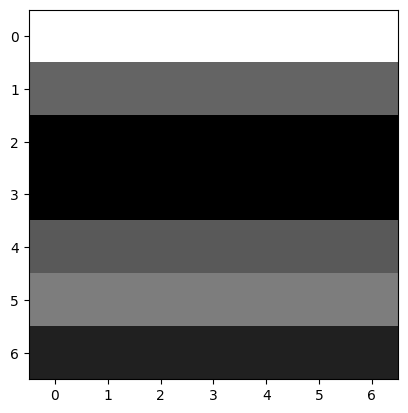

In [2]:
import matplotlib.pyplot as plt
model.layers[0].params_delta['dW'].shape
plt.imshow(model.layers[0].params_delta['dW'][0].permute(1, 2, 0).cpu().numpy(), cmap='gray')

tensor([1], device='cuda:0')


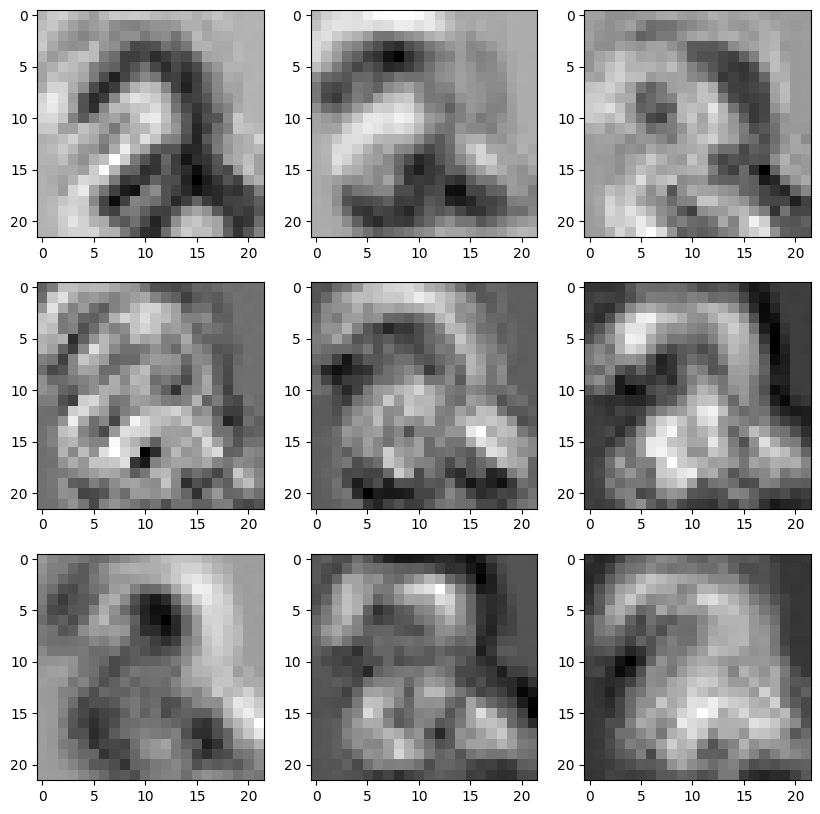

In [3]:


target_layer = 1
sample_idx = 41
print(model.get_pred(torch.tensor(np.expand_dims(x_all[sample_idx], axis=0)).cuda(), with_onehot=False))

plt.figure(figsize=(10, 10))
plot_size = np.ceil(np.sqrt(len(model.layers[target_layer].in_feat[0]))).astype(int)
for idx, activation in enumerate(model.layers[target_layer].in_feat[0]):
    plt.subplot(plot_size, plot_size, idx + 1)    
    plt.imshow(np.expand_dims(activation.cpu().numpy(), axis=0).transpose(1, 2, 0), cmap='gray')
    

In [1]:
import torch
from torchvision import datasets, transforms
from my_nn_lib_torch import Conv2d, LeckyReLU, Linear, Softmax, Flatten, MyModel, CrossEntropyLoss


# 載入訓練和測試資料集
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)



model = MyModel([Conv2d(3, 9, (7, 7), 1, 0), 
                LeckyReLU(),
                Conv2d(9, 3, (5, 5), 1, 0),
                LeckyReLU(),
                Flatten(),
                Linear(3*22*22, 10),
                Softmax()])

hyper_params = {    
    'lr': 0.005,
    'epoch': 10,
    'batch_size': 64,
    'alpha': 0.9
}
model.train_with_dataset(train_dataset, CrossEntropyLoss, hyper_params, show_plot=True)



Files already downloaded and verified
Epoch:  0


train::   0%|          | 0/625 [00:00<?, ?it/s]

torch.Size([1, 9]) torch.Size([1, 9, 1, 9])


RuntimeError: output with shape [1, 9] doesn't match the broadcast shape [1, 9, 1, 9]

In [25]:
import torch
import numpy as np

a = np.random.randint(0, 20, size=(2, 7, 3, 3)).astype(np.float32)
a_torch = torch.tensor(a)
# a.transpose(0, 2, 3, 1).shape
torch.randn(5, 6) * np.sqrt(2 / 5)

tensor([[-0.7417, -0.9318,  0.3599,  0.7474, -0.5783,  1.8770],
        [ 1.4013,  0.1750, -0.1525, -0.4372,  0.8088,  0.0652],
        [-0.6041, -0.2375,  0.0911,  0.1880,  0.2377, -0.0834],
        [ 0.3751, -0.2055, -0.4353,  1.0228,  0.0154, -0.4575],
        [-0.0798,  0.8257, -0.1885, -0.4419, -0.4577,  0.0160]])